### Exercise 1: Image Gradient (Football)
- Goal: Compute gradient magnitude and orientation to isolate features (like the seam of a ball) .

- Theory:
    - Magnitude: $\sqrt{G_x^2 + G_y^2}$ (Strengh of the edge).

    - Orientation: $\arctan(G_y / G_x)$ (Direction of the edge).

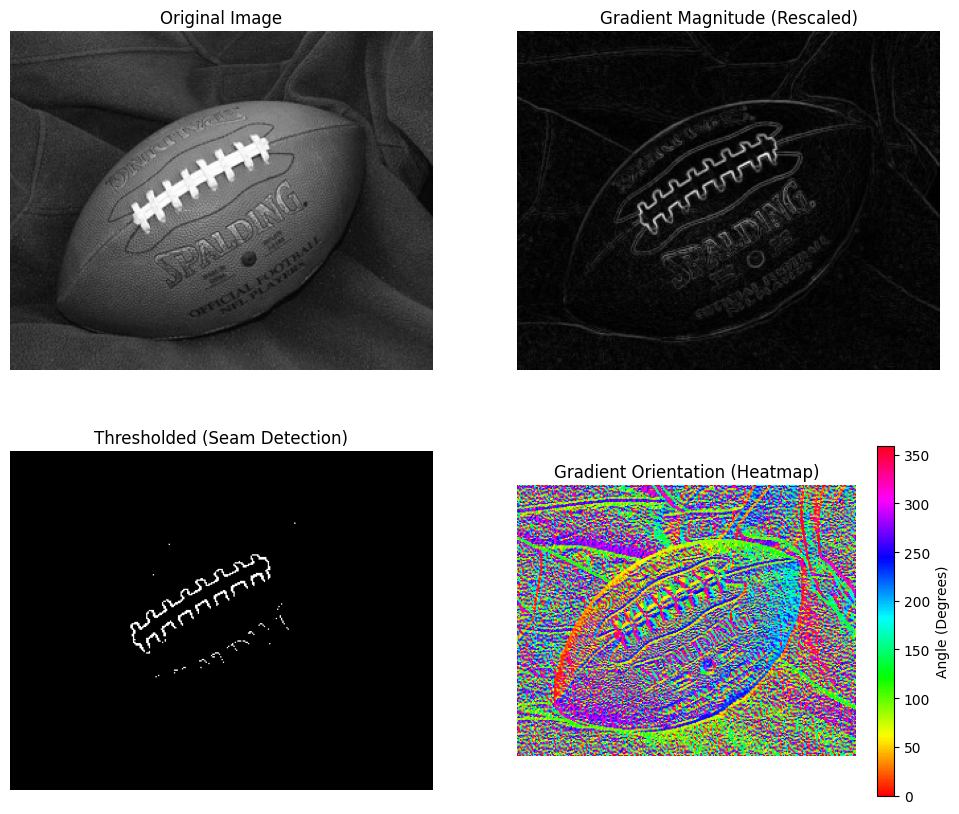

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def analyze_gradient(image_path):
    # 1. Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Could not load {image_path}. Using a fallback image.")
        # Fallback: Create a simple circle image
        img = np.zeros((300, 300), dtype=np.uint8)
        cv2.circle(img, (150, 150), 100, 255, -1)
    
    # 2. Compute Gradients (using cv2.Sobel)
    # CV_64F keeps the float values (negative derivatives)
    gx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    
    # 3. Compute Magnitude
    magnitude = cv2.magnitude(gx, gy)
    
    # Rescale to 0-255
    if magnitude.max() > 0:
        magnitude_norm = (magnitude / magnitude.max()) * 255
    else:
        magnitude_norm = magnitude
    magnitude_norm = magnitude_norm.astype(np.uint8)
    
    # 4. Threshold (e.g., at 100) to isolate strong edges (the seam)
    _, seam_only = cv2.threshold(magnitude_norm, 100, 255, cv2.THRESH_BINARY)
    
    # 5. Compute Orientation (Heatmap)
    # phase calculates the angle in degrees or radians
    # angleInDegrees=True -> range 0 to 360
    orientation = cv2.phase(gx, gy, angleInDegrees=True)
    
    return img, magnitude_norm, seam_only, orientation

# --- Test ---
img, mag, seam, orient = analyze_gradient('img/football.jpg')

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.title("Original Image")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("Gradient Magnitude (Rescaled)")
plt.imshow(mag, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title("Thresholded (Seam Detection)")
plt.imshow(seam, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title("Gradient Orientation (Heatmap)")
# HSV usually better for orientation, but 'hsv' cmap works for demo
plt.imshow(orient, cmap='hsv') 
plt.colorbar(label='Angle (Degrees)')
plt.axis('off')

plt.show()

### Exercise 2: Hough Transform
- Goal: Detect geometric shapes (lines and circles) in images using the Hough Transform .
- Theory:
    - Hough Lines: Transforms points in image space $(x,y)$ to parameter space $(\rho, \theta)$. Lines in the image correspond to intersecting curves in parameter space. HoughLines returns all lines, while HoughLinesP (Probabilistic) returns specific line segments .
    - Hough Circles: Uses a similar voting mechanism in 3D parameter space $(x, y, r)$ to find circles.

load corridor.png for lines and coins.png for circles

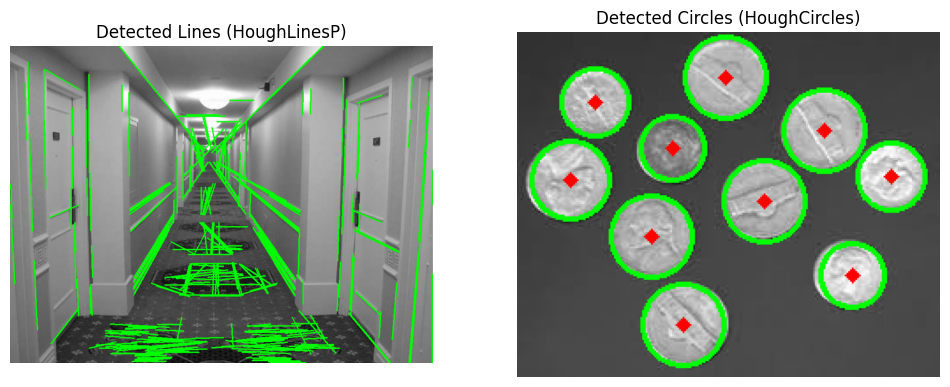

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def detect_lines_and_circles():
    plt.figure(figsize=(12, 6))

    # --- Part 1: Line Detection (Corridor) ---
    img_lines = cv2.imread("img/corridor.png")
    if img_lines is None:
        print("Corridor image not found. Generating synthetic image.")
        img_lines = np.zeros((300, 300, 3), dtype=np.uint8)
        cv2.line(img_lines, (50, 50), (250, 50), (255, 255, 255), 3)
        cv2.line(img_lines, (50, 50), (50, 250), (255, 255, 255), 3)

    gray_lines = cv2.cvtColor(img_lines, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_lines, 50, 150, apertureSize=3)

    # Probabilistic Hough Transform (more efficient, returns endpoints)
    # minLineLength: Minimum length of line. Line segments shorter than this are rejected.
    # maxLineGap: Maximum allowed gap between line segments to treat them as single line.
    lines = cv2.HoughLinesP(
        edges, 1, np.pi / 180, threshold=50, minLineLength=50, maxLineGap=10
    )

    # Draw lines on a copy
    img_lines_out = img_lines.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(img_lines_out, (x1, y1), (x2, y2), (0, 255, 0), 2)

    plt.subplot(1, 2, 1)
    plt.title("Detected Lines (HoughLinesP)")
    plt.imshow(cv2.cvtColor(img_lines_out, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    # --- Part 2: Circle Detection (Coins2) ---
    img_circles = cv2.imread("img/coins.png")
    if img_circles is None:
        # Fallback if coins2.png is missing
        img_circles = np.zeros((300, 300, 3), dtype=np.uint8)
        cv2.circle(img_circles, (150, 150), 50, (255, 255, 255), -1)

    gray_circles = cv2.cvtColor(img_circles, cv2.COLOR_BGR2GRAY)

    # Pre-processing: Blur is critical for HoughCircles to avoid false positives
    gray_circles = cv2.medianBlur(gray_circles, 5)

    # HoughCircles (Gradient method)
    # dp: Inverse ratio of the accumulator resolution (1 = same resolution)
    # minDist: Minimum distance between the centers of the detected circles
    # param1: Higher threshold for Canny edge detector
    # param2: Accumulator threshold (lower = more circles detected)
    circles = cv2.HoughCircles(
        gray_circles,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=20,
        param1=50,
        param2=30,
        minRadius=10,
        maxRadius=50,
    )

    img_circles_out = img_circles.copy()
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            # Draw the outer circle
            cv2.circle(img_circles_out, (i[0], i[1]), i[2], (0, 255, 0), 2)
            # Draw the center of the circle
            cv2.circle(img_circles_out, (i[0], i[1]), 2, (0, 0, 255), 3)

    plt.subplot(1, 2, 2)
    plt.title("Detected Circles (HoughCircles)")
    plt.imshow(cv2.cvtColor(img_circles_out, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.show()


detect_lines_and_circles()

### Exercises 3 & 4: Keypoint Detection (Harris & FAST)
- Goal: Detect "interest points" or corners in an image. These are features that are distinct and trackable, even if the image is rotated or scaled. We will compare two methods:


Harris Corner Detector: A classic mathematical approach based on eigenvalues of the structure tensor .


FAST (Features from Accelerated Segment Test): A high-speed algorithm optimized for real-time applications .

Task:

Detect corners on the original image.

Rotate the image and detect corners again to verify that the detector is "rotation invariant" (it finds the same physical points).

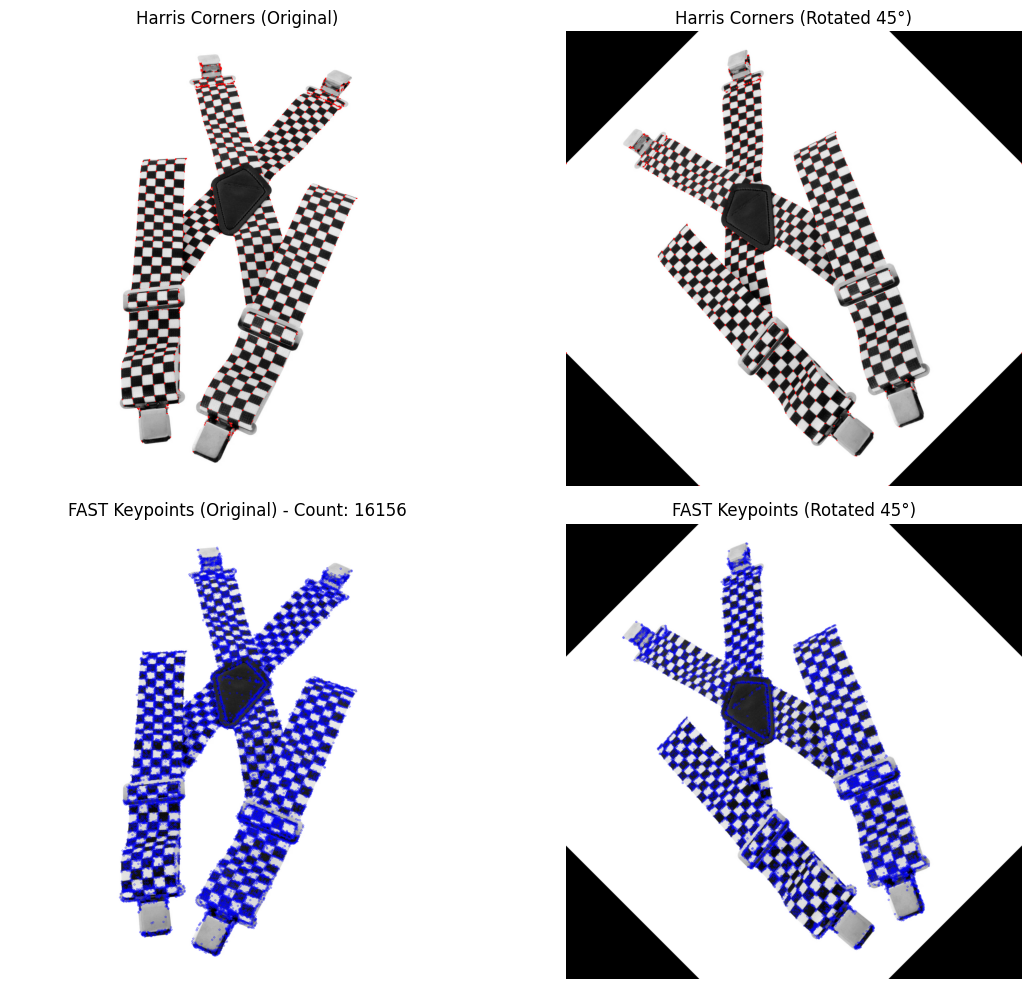

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def rotate_image(image, angle):
    """Helper to rotate an image by a specific angle."""
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

def keypoint_detection_demo():
    # 1. Load Image
    # PDF suggests 'bretelle.jpg', but 'coins.png' or 'cameraman' works too if missing.
    # We'll use 'img/bretelle.jpg' if available, else fallback.
    img_path = 'img/bretelle.jpg'
    img = cv2.imread(img_path)
    
    if img is None:
        print(f"Could not load {img_path}. Using fallback.")
        img = np.zeros((300, 300, 3), dtype=np.uint8)
        cv2.rectangle(img, (50, 50), (250, 250), (255, 255, 255), -1) # White square
        cv2.rectangle(img, (100, 100), (200, 200), (0, 0, 0), -1)   # Black hole

    # Create a rotated version for testing
    img_rot = rotate_image(img, 45)

    plt.figure(figsize=(12, 10))

    # --- HARRIS CORNER DETECTION ---
    # It requires grayscale and float32 input
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    
    # cv2.cornerHarris(img, blockSize, ksize, k)
    # blockSize: Neighborhood size
    # ksize: Aperture parameter for Sobel
    # k: Harris detector free parameter
    dst = cv2.cornerHarris(gray, 2, 3, 0.04)
    
    # Result is dilated for marking the corners, not important for actual detection
    dst = cv2.dilate(dst, None)

    # Threshold for an optimal value, it may vary depending on the image.
    img_harris = img.copy()
    img_harris[dst > 0.01 * dst.max()] = [0, 0, 255] # Mark red

    # Apply to Rotated Image
    gray_rot = cv2.cvtColor(img_rot, cv2.COLOR_BGR2GRAY)
    gray_rot = np.float32(gray_rot)
    dst_rot = cv2.cornerHarris(gray_rot, 2, 3, 0.04)
    dst_rot = cv2.dilate(dst_rot, None)
    img_harris_rot = img_rot.copy()
    img_harris_rot[dst_rot > 0.01 * dst_rot.max()] = [0, 0, 255]

    # --- FAST FEATURE DETECTOR ---
    # Create FAST object with default values
    fast = cv2.FastFeatureDetector_create()

    # Find and draw keypoints
    kp = fast.detect(img, None)
    img_fast = cv2.drawKeypoints(img, kp, None, color=(255, 0, 0))

    # Find and draw on Rotated Image
    kp_rot = fast.detect(img_rot, None)
    img_fast_rot = cv2.drawKeypoints(img_rot, kp_rot, None, color=(255, 0, 0))

    # --- DISPLAY ---
    plt.subplot(2, 2, 1)
    plt.title("Harris Corners (Original)")
    plt.imshow(cv2.cvtColor(img_harris, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.title("Harris Corners (Rotated 45°)")
    plt.imshow(cv2.cvtColor(img_harris_rot, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.title(f"FAST Keypoints (Original) - Count: {len(kp)}")
    plt.imshow(cv2.cvtColor(img_fast, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.title(f"FAST Keypoints (Rotated 45°)")
    plt.imshow(cv2.cvtColor(img_fast_rot, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

keypoint_detection_demo()